# Imports

In [8]:
import pandas as pd
import numpy as np
import sys
sys.path.append('/warehouse/COMPLEXNET/jlevyabi/TWITTERSES/ml_soc_econ/data_files/UKSOC_rep/')
from helpers_locs_to_home import time_2_date
from collections import Counter

from tqdm import tqdm_notebook as tqdmn
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as tkr
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import classification_report
from helpers_locs_to_home import *

import pickle
import re;pat = re.compile(r'''(-*\d+\.\d+ -*\d+\.\d+);*''');new_geo=[]
import warnings
import seaborn as sns


# Load Relevant Data

In [9]:
import pickle
usrs_with_SES_info_dic=pickle.load(open("/warehouse/COMPLEXNET/jlevyabi/TWITTERSES/ml_soc_econ/usrs_with_SES_info_dic.p",
                                        "rb"))
inter={}
for k,v in tqdmn(usrs_with_SES_info_dic.items()):
    v=v.rename(index=str, columns={"min": "minu","nb urls":"text"})
    inter[k]=v

usrs_with_SES_info_dic=inter
del inter

HBox(children=(IntProgress(value=0, max=127614), HTML(value='')))

In [10]:
dec_prec=5
nb_rep_thresh=10
pre_fake_locs=pd.read_csv("/warehouse/COMPLEXNET/jlevyabi/TWITTERSES/geoloc/txt_files/fake_locs.txt",
                          names=["pre"])
fake_locs=[]
for x in pre_fake_locs.pre:
    try:
        lat,lon=round(float(x.split("-")[0]),dec_prec),round(float(x.split("-")[-1]),dec_prec)
    except:
        continue
    if len(x)==3:
        fake_locs.append(str((round(lat,dec_prec),-round(lon,dec_prec))))
    else:
        fake_locs.append(str((round(lat,dec_prec),round(lon,dec_prec))))

set_toher_fakes=list(set(fake_locs))

# Filters

In [11]:
max_km_var=10
max_km_per_h=120
nb_mini_locs=5
nb_min_crazy=20
thresh_rate=3

dic_locs_reals,d_locs_fast,d_locs_vars,dic_mar,dic_dist,dic_speed,pre_home=fast_get_repr_location(
    dic_locs=usrs_with_SES_info_dic,
    max_km_var=max_km_var,
    max_km_per_h=max_km_per_h,
    nb_mini_locs=nb_mini_locs,
    nb_min_crazy=nb_min_crazy)

#new_dic_real,activ_static_usrs=remove_active_static_usrs(dic_real=dic_locs_reals,pandas_version=0)
new_dic_real_normal_activ,hyper_active_usrs=remove_hyperactive_usrs(dic_locs_reals,pandas_version=0,thresh_rate=thresh_rate)
new_dic_real_normal_social,hyper_social_usrs_home=remove_hyper_social_usrs(dic_real=new_dic_real_normal_activ)

print("Number of users before filtering... %d"%len(usrs_with_SES_info_dic.keys()))
print("Users going too fast... %d"%len(d_locs_fast))
print("Users too variable ... %d"%len(d_locs_vars))
print("Weather bots ... %d"%len(dic_mar))
print("Real users with more than %d locations ...%d"%(nb_mini_locs,len(dic_locs_reals)))
print("Users posting 2 consecutive tweets in less than 2 secs  ... %d"%len(hyper_active_usrs))
print("Users with too many followers/friends ... %d"%len(hyper_social_usrs_home))
print("Final nb of users  %d"%len(new_dic_real_normal_social))

HBox(children=(IntProgress(value=0, max=127614), HTML(value='')))

HBox(children=(IntProgress(value=0, max=53787), HTML(value='')))


Number of users before filtering... 127614
Users going too fast... 0
Users too variable ... 1099
Weather bots ... 818
Real users with more than 5 locations ...53787
Users posting 2 consecutive tweets in less than 2 secs  ... 13814
Users with too many followers/friends ... 0
Final nb of users  39973


In [40]:
import numpy as np
from tqdm import tqdm_notebook as tqdmn

# Gini Coefficient determined by here: https://es.wikipedia.org/wiki/Coeficiente_de_Gini
def gini(cum_pob,cum_inc):
    return np.abs(1-np.sum((cum_pob[1:]-cum_pob[:-1])*(cum_inc[:-1]+cum_inc[1:])))

# Create Income Distribution plots from salary data
def yannick_plots(ses_distribution):
    nb_users=len(ses_distribution)
    sorted_ses=np.sort(ses_distribution)
    frac_of_users=np.arange(nb_users,dtype=float)/nb_users
    frac_of_income=np.cumsum(sorted_ses)
    frac_of_income=frac_of_income/np.max(frac_of_income)
    return frac_of_users,frac_of_income

def get_gini_for_userset(user_ses_dic,min_t=0,min_d=0):
    thresh= lambda x: take_most_frequent_thresh(x,min_times=min_t,min_days=min_d)
    home_most_freq_all=go_through_home_candidates(user_ses_dic,thresh)
    dic_all_users_insee={usr:{"profile":(user_ses_dic[usr].profile),
                              "locations":user_ses_dic[usr][["lat","lon","text",
                                                   "day", "hour","minu","sec",
                                                   "year","month","fecha",
                                                   "geo_pt","service"]],
                              "inferred_loc":home_most_freq_all[usr][["lat","lon"]],
                              "suppl_info":home_most_freq_all[usr]} 
                         for usr in (home_most_freq_all.keys()) }
    #
    usr2ses=pd.DataFrame([[k,v["inferred_loc"],v["suppl_info"]["income"],v["suppl_info"]["DEC_D113"],
                           v["suppl_info"]["DEC_MED13"],v["suppl_info"]["DEC_D913"],v["suppl_info"]["DEC_GI13"]]
                          for k,v in dic_all_users_insee.items()],
                         columns=["usr","geom","insee_income","insee_iris_lowe",
                                  "insee_iris_med","insee_iris_sup","gini"]).dropna(how="any")
    return usr2ses

In [41]:
usr2ses_ori=get_gini_for_userset(usrs_with_SES_info_dic)
usr2ses_locs_reals=get_gini_for_userset(dic_locs_reals)
usr2ses_normal_activ=get_gini_for_userset(new_dic_real_normal_activ)
usr2ses_real_normal_social=get_gini_for_userset(new_dic_real_normal_social)
usr2ses_final=get_gini_for_userset(new_dic_real_normal_social,min_t=5,min_d=1)

HBox(children=(IntProgress(value=0, max=127614), HTML(value='')))

HBox(children=(IntProgress(value=0, max=53787), HTML(value='')))

HBox(children=(IntProgress(value=0, max=39973), HTML(value='')))

HBox(children=(IntProgress(value=0, max=39973), HTML(value='')))

HBox(children=(IntProgress(value=0, max=39973), HTML(value='')))

GINI decreases to value closer to real one by one centesimal —> WHY? (Many locations are bad (100k of 1.3M in geo center of paris) BUT few users concentrate most of these locations AND when switching to iris no data available for some of these spots (see paris) so no big change in user GINI however main utility of filtering is to ensure that the estimated home location is indeed the correct one (ex: teens moving from school to home both areas of same gini but filter ensures detection of home  ))

# Filter Justification

## GINI?

In [50]:
np.average(usr2ses_ori.gini)

0.37316486676088556

In [51]:
np.average(usr2ses_final.gini)

0.3647730682178367

In [52]:
np.average(d_filo_dec_iris.DEC_GI13)

0.36474353574602614

In [ ]:
dic_iris={
    "usr2ses_ori":usr2ses_ori,
    "usr2ses_final":usr2ses_final,
    "d_filo_dec_iris":d_filo_dec_iris,
}
import pickle
pickle.dump(dic_iris,
            open("/warehouse/COMPLEXNET/jlevyabi/TWITTERSES/ml_soc_econ/icdm18/issues/dic_iris_icdwm18_filters.p","wb"))

In [ ]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import pickle
from geopandas import GeoDataFrame
import pandas as pd

dic_iris=pickle.load(open("/warehouse/COMPLEXNET/jlevyabi/TWITTERSES/ml_soc_econ/icdm18/issues/dic_iris_icdwm18_filters.p","rb"))

usr2ses_ori=dic_iris["usr2ses_ori"]
usr2ses_final=dic_iris["usr2ses_final"]
d_filo_dec_iris=dic_iris["d_filo_dec_iris"]


geo_usr2ses_ori=usr2ses_ori
geo_usr2ses_ori["geometry"]=[Point(x.lon,x.lat)for x in usr2ses_ori.geom]
geo_usr2ses_ori=GeoDataFrame(geo_usr2ses_ori)

geo_usr2ses_final=usr2ses_final
geo_usr2ses_final["geometry"]=[Point(x.lon,x.lat)for x in usr2ses_final.geom]
geo_usr2ses_final=GeoDataFrame(geo_usr2ses_final)

## Population

### Arrondissement

#### Original

In [123]:
from tqdm import tqdm_notebook as tqdmn
geo_file="/warehouse/COMPLEXNET/jlevyabi/TWITTERSES/geoloc/france-geojson/arrondissements.geojson"
import json
with open(geo_file) as f:
    arro_data=json.load(f)
    
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
df = gpd.read_file(geo_file)
codes=[];names=[]
for point in tqdmn(usr2ses_ori.geometry):
    indi=list(map(lambda poly:poly.contains(point),df.geometry))
    res_code,res_name=(df.code[indi],df.nom[indi])
    if len(res_code)==0:
        code,name=(None,None)
    else:
        code,name=(list(res_code.to_dict().values())[0],list(res_name.to_dict().values())[0])
    codes.append(code);names.append(name)

usr2ses_ori['Codes']=codes
usr2ses_ori['Names']=names

A Jupyter Widget

In [124]:
import xlrd
path = "/warehouse/COMPLEXNET/jlevyabi/TWITTERSES/geoloc/france-geojson/ensemble.xls"
workbook = xlrd.open_workbook(path)
worksheet = workbook.sheet_by_name("Arrondissements")
offset = 6

rows = []
for i, row in enumerate(range(worksheet.nrows)):
    if i <= offset:  # (Optionally) skip headers
        continue
    r = []
    for j, col in enumerate(range(worksheet.ncols)):
        r.append(worksheet.cell_value(i, j))
    rows.append(r)
    
d_exc=pd.DataFrame(rows[1:],columns=rows[0])
d_exc['Codes']=[u+'%03d'%int(v) for u,v in zip(d_exc['Code département'],d_exc['Code arrondissement'])]
d_exc.head()

,Code région,Nom de la région,Code département,Nom du département,Code arrondissement,Nom de l'arrondissement,Nombre de communes,Population municipale,Population totale,Codes
0,82,Rhône-Alpes,01,Ain,1,Belley,107.0,97136.0,99839.0,01001
1,82,Rhône-Alpes,01,Ain,2,Bourg-en-Bresse,219.0,350548.0,360208.0,01002
2,82,Rhône-Alpes,01,Ain,3,Gex,29.0,87153.0,89529.0,01003
3,82,Rhône-Alpes,01,Ain,4,Nantua,64.0,84660.0,87340.0,01004
4,22,Picardie,02,Aisne,1,Château-Thierry,123.0,72657.0,74629.0,02001


In [125]:
geo_arr_ori=(usr2ses_ori.Codes.value_counts()).to_frame()
geo_arr_ori.reset_index(inplace=True)
geo_arr_ori.columns=['Codes','nb_usrs']
geo_arr_ori.head()

,Codes,nb_usrs
0,75001,7488
1,59005,2891
2,92002,2188
3,13003,1587
4,94001,1555


In [126]:
d_insee=d_exc[['Codes','Population totale']]
#d_insee['Population totale']=(d_insee['Population totale']+0.0)/sum(d_insee['Population totale'])
d_corr=pd.merge(d_insee,geo_arr_ori,on='Codes')
d_corr.head()

,Codes,Population totale,nb_usrs
0,01001,99839.0,4
1,01002,360208.0,48
2,01004,87340.0,19
3,02001,74629.0,12
4,02002,170122.0,69


/home/jlevyabi/seacabo/geoanaconda/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


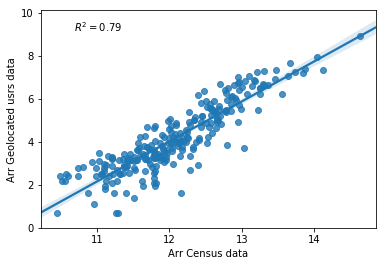

In [127]:
import seaborn as sns
import scipy.stats as st
import numpy as np
sns.regplot(np.log(d_corr['Population totale']),np.log(d_corr['nb_usrs']))
rsquare = st.pearsonr(np.log(d_corr['Population totale']),np.log(d_corr['nb_usrs']))[0]**2
plt.annotate("$R^2=%.2f$"%round(rsquare,2), xy=(0.1, 0.9), xycoords='axes fraction')
plt.ylabel('Arr Geolocated usrs data')
plt.xlabel('Arr Census data')
plt.show()

#### Final

In [114]:
from tqdm import tqdm_notebook as tqdmn
geo_file="/warehouse/COMPLEXNET/jlevyabi/TWITTERSES/geoloc/france-geojson/arrondissements.geojson"
import json
with open(geo_file) as f:
    arro_data=json.load(f)
    
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
df = gpd.read_file(geo_file)
codes=[];names=[]
for point in tqdmn(usr2ses_final.geometry):
    indi=list(map(lambda poly:poly.contains(point),df.geometry))
    res_code,res_name=(df.code[indi],df.nom[indi])
    if len(res_code)==0:
        code,name=(None,None)
    else:
        code,name=(list(res_code.to_dict().values())[0],list(res_name.to_dict().values())[0])
    codes.append(code);names.append(name)

usr2ses_final['Codes']=codes
usr2ses_final['Names']=names

A Jupyter Widget

In [116]:
import xlrd
path = "/warehouse/COMPLEXNET/jlevyabi/TWITTERSES/geoloc/france-geojson/ensemble.xls"
workbook = xlrd.open_workbook(path)
worksheet = workbook.sheet_by_name("Arrondissements")
offset = 6

rows = []
for i, row in enumerate(range(worksheet.nrows)):
    if i <= offset:  # (Optionally) skip headers
        continue
    r = []
    for j, col in enumerate(range(worksheet.ncols)):
        r.append(worksheet.cell_value(i, j))
    rows.append(r)
    
d_exc=pd.DataFrame(rows[1:],columns=rows[0])
d_exc['Codes']=[u+'%03d'%int(v) for u,v in zip(d_exc['Code département'],d_exc['Code arrondissement'])]
d_exc.head()

,Code région,Nom de la région,Code département,Nom du département,Code arrondissement,Nom de l'arrondissement,Nombre de communes,Population municipale,Population totale,Codes
0,82,Rhône-Alpes,01,Ain,1,Belley,107.0,97136.0,99839.0,01001
1,82,Rhône-Alpes,01,Ain,2,Bourg-en-Bresse,219.0,350548.0,360208.0,01002
2,82,Rhône-Alpes,01,Ain,3,Gex,29.0,87153.0,89529.0,01003
3,82,Rhône-Alpes,01,Ain,4,Nantua,64.0,84660.0,87340.0,01004
4,22,Picardie,02,Aisne,1,Château-Thierry,123.0,72657.0,74629.0,02001


In [118]:
geo_arr_final=(usr2ses_final.Codes.value_counts()).to_frame()
geo_arr_final.reset_index(inplace=True)
geo_arr_final.columns=['Codes','nb_usrs']
geo_arr_final.head()

,Codes,nb_usrs
0,75001,1270
1,59005,877
2,92002,589
3,93002,491
4,93001,474


In [ ]:
d_insee=d_exc[['Codes','Population totale']]
#d_insee['Population totale']=(d_insee['Population totale']+0.0)/sum(d_insee['Population totale'])
d_corr=pd.merge(d_insee,geo_arr_final,on='Codes')
d_corr.head()

/home/jlevyabi/seacabo/geoanaconda/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


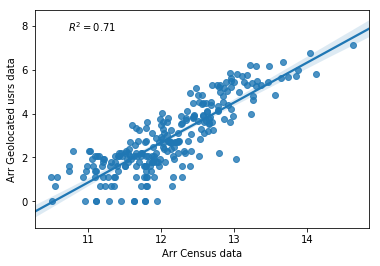

In [121]:
import seaborn as sns
import scipy.stats as st
import numpy as np
sns.regplot(np.log(d_corr['Population totale']),np.log(d_corr['nb_usrs']))
rsquare = st.pearsonr(np.log(d_corr['Population totale']),np.log(d_corr['nb_usrs']))[0]**2
plt.annotate("$R^2=%.2f$"%round(rsquare,2), xy=(0.1, 0.9), xycoords='axes fraction')
plt.ylabel('Arr Geolocated usrs data')
plt.xlabel('Arr Census data')
plt.show()

### Commune Level

#### Ori

In [ ]:
from tqdm import tqdm as tqdmn
geo_file="/warehouse/COMPLEXNET/jlevyabi/TWITTERSES/geoloc/france-geojson/communes.geojson"
import json
with open(geo_file) as f:
    arro_data=json.load(f)


import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
df = gpd.read_file(geo_file)
codes=[];names=[]
for point in tqdmn(usr2ses_ori.geometry):
    indi=list(map(lambda poly:poly.contains(point),df.geometry))
    res_code,res_name=(df.code[indi],df.nom[indi])
    if len(res_code)==0:
        code,name=(None,None)
    else:
        code,name=(list(res_code.to_dict().values())[0],list(res_name.to_dict().values())[0])
    codes.append(code);names.append(name)


usr2ses_ori['Codes']=codes
usr2ses_ori['Names']=names

In [144]:
import xlrd
path = "/warehouse/COMPLEXNET/jlevyabi/TWITTERSES/geoloc/france-geojson/ensemble.xls"
workbook = xlrd.open_workbook(path)
worksheet = workbook.sheet_by_name("Communes")
offset = 6

rows = []
for i, row in enumerate(range(worksheet.nrows)):
    if i <= offset:  # (Optionally) skip headers
        continue
    r = []
    for j, col in enumerate(range(worksheet.ncols)):
        r.append(worksheet.cell_value(i, j))
    rows.append(r)

    
d_exc=pd.DataFrame(rows[1:],columns=rows[0])
d_exc['Codes']=[u+'%03d'%int(v) for u,v in zip(d_exc['Code département'],d_exc['Code commune'])]
d_exc.head()

,Code région,Nom de la région,Code département,Code arrondissement,Code canton,Code commune,Nom de la commune,Population municipale,Population comptée à part,Population totale,Codes
0,82,Rhône-Alpes,01,2,08,001,L' Abergement-Clémenciat,767.0,13.0,780.0,01001
1,82,Rhône-Alpes,01,1,01,002,L' Abergement-de-Varey,236.0,4.0,240.0,01002
2,82,Rhône-Alpes,01,1,01,004,Ambérieu-en-Bugey,14359.0,529.0,14888.0,01004
3,82,Rhône-Alpes,01,2,22,005,Ambérieux-en-Dombes,1635.0,31.0,1666.0,01005
4,82,Rhône-Alpes,01,1,04,006,Ambléon,108.0,6.0,114.0,01006


In [125]:
geo_arr_ori=(usr2ses_ori.Codes.value_counts()).to_frame()
geo_arr_ori.reset_index(inplace=True)
geo_arr_ori.columns=['Codes','nb_usrs']
geo_arr_ori.head()

,Codes,nb_usrs
0,75001,7488
1,59005,2891
2,92002,2188
3,13003,1587
4,94001,1555


In [126]:
d_insee=d_exc[['Codes','Population totale']]
#d_insee['Population totale']=(d_insee['Population totale']+0.0)/sum(d_insee['Population totale'])
d_corr=pd.merge(d_insee,geo_arr_ori,on='Codes')
d_corr.head()

,Codes,Population totale,nb_usrs
0,01001,99839.0,4
1,01002,360208.0,48
2,01004,87340.0,19
3,02001,74629.0,12
4,02002,170122.0,69


/home/jlevyabi/seacabo/geoanaconda/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


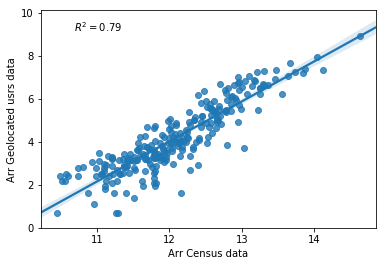

In [127]:
import seaborn as sns
import numpy as np
import scipy.stats as st
sns.regplot(np.log(d_corr['Population totale']),np.log(d_corr['nb_usrs']))
rsquare = st.pearsonr(np.log(d_corr['Population totale']),np.log(d_corr['nb_usrs']))[0]**2
plt.annotate("$R^2=%.2f$"%round(rsquare,2), xy=(0.1, 0.9), xycoords='axes fraction')
plt.ylabel('Arr Geolocated usrs data')
plt.xlabel('Arr Census data')
plt.show()

#### Final

In [ ]:
from tqdm import tqdm as tqdmn
geo_file="/warehouse/COMPLEXNET/jlevyabi/TWITTERSES/geoloc/france-geojson/communes.geojson"
import json
with open(geo_file) as f:
    arro_data=json.load(f)


import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
df = gpd.read_file(geo_file)
codes=[];names=[]
for point in tqdmn(usr2ses_final.geometry):
    indi=list(map(lambda poly:poly.contains(point),df.geometry))
    res_code,res_name=(df.code[indi],df.nom[indi])
    if len(res_code)==0:
        code,name=(None,None)
    else:
        code,name=(list(res_code.to_dict().values())[0],list(res_name.to_dict().values())[0])
    codes.append(code);names.append(name)


usr2ses_final['Codes']=codes
usr2ses_final['Names']=names

In [ ]:
import seaborn as sns
import scipy.stats as st
import numpy as np
sns.regplot(np.log(d_corr['Population totale']),np.log(d_corr['nb_usrs']))
rsquare = st.pearsonr(np.log(d_corr['Population totale']),np.log(d_corr['nb_usrs']))[0]**2
plt.annotate("$R^2=%.2f$"%round(rsquare,2), xy=(0.1, 0.9), xycoords='axes fraction')
plt.ylabel('Arr Geolocated usrs data')
plt.xlabel('Arr Census data')
plt.show()

### IRIS LEVEL

In [22]:
import geopandas as gpd
import xlrd,json
from geopandas import sjoin

def extract_xls_file(path,sheet_name,offset):
    workbook = xlrd.open_workbook(path)
    worksheet = workbook.sheet_by_name(sheet_name)
    rows = []
    for i, row in (enumerate(range(worksheet.nrows))):
        if i <= offset:  # (Optionally) skip headers
            continue
        r = []
        for j, col in enumerate(range(worksheet.ncols)):
            r.append(worksheet.cell_value(i, j))
        rows.append(r)
    return(pd.DataFrame(rows[1:],columns=rows[0]))


geo_file="/warehouse/COMPLEXNET/jlevyabi/TWITTERSES/geoloc/iris_opendata/shapefile_iris/contours-iris-2016.geojson"
df = gpd.read_file(geo_file)
france=Polygon([[-4.9658203125,42.3585439175],[8.4375,42.3585439175],
                [8.4375,51.2344073516],[-4.9658203125,51.2344073516],[-4.9658203125,42.3585439175]])

d_iris=df[[france.contains(geo_pt) if geo_pt else False for geo_pt in (df.geometry)]]
d_iris['IRIS']=d_iris.code_iris

f0="/warehouse/COMPLEXNET/jlevyabi/TWITTERSES/geoloc/iris_opendata/RFDM2010IRI.xls"
d_exc=extract_xls_file(f0,"Distribution_Ménages",5)
d_exc_iris=pd.merge(d_iris, d_exc, on='IRIS')

geo_usr2ses_final.crs={'init': 'epsg:4326'}
d_exc_iris.crs={'init': 'epsg:4326'}
usrs_with_iris_demo = sjoin(geo_usr2ses_final, d_exc_iris, how="inner", op='within')

/home/jlevyabi/seacabo/geoanaconda/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


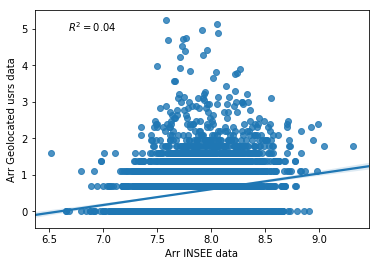

In [73]:
import scipy.stats as st
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 
real_final_pop=d_exc_iris[["IRIS","p12_pop"]]
twitter_final_pop=usrs_with_iris_demo.groupby("IRIS")["usr"].count().reset_index()
final_comp=pd.merge(real_final_pop,twitter_final_pop,on="IRIS")

sns.regplot(np.log(final_comp.p12_pop),np.log(final_comp.usr))
rsquare = st.pearsonr(np.log(final_comp.p12_pop),np.log(final_comp.usr))[0]**2
plt.annotate("$R^2=%.2f$"%round(rsquare,2), xy=(0.1, 0.9), xycoords='axes fraction')
plt.ylabel('Arr Geolocated usrs data')
plt.xlabel('Arr INSEE data')
plt.show()

# Helpers

## Location Helpers

In [14]:
uk = '+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 \
+x_0=400000 +y_0=-100000 +ellps=airy \
+towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs'
from pyproj import transform,Proj

def proj_arr(points,proj_to):
    inproj = Proj(init='epsg:4326')
    outproj = Proj(proj_to)
    func = lambda x: transform(inproj,outproj,x[1],x[0])
    return np.array(list(map(func, points)))

def take_most_frequent_thresh(geopandas_usr,min_times=5,min_days=1):
    polys_visited=list(geopandas_usr.idINSPIRE)
    time_of_visit=[datetime(int(row.year),int(row.month),int(row.fecha),
                            int(row.hour),int(row.minu),int(row.sec))
                   for it,row in geopandas_usr.iterrows()]
    locat_mode=Counter(polys_visited).most_common(1)[0][0]
    nb_times=Counter(polys_visited).most_common(1)[0][1]
    inter_idx=np.where([x==locat_mode for x in polys_visited])[0].tolist()
    time_diff=[time_of_visit[i] for i in inter_idx]
    if nb_times>=min_times and (max(time_diff)-min(time_diff)).days>=min_days:
        idx_mode=polys_visited.index(locat_mode)
        return idx_mode,geopandas_usr.iloc[idx_mode][["lat","lon"]]
    else:
        return None,None

def get_check_in_rate_margin_most_freq(geopandas_usr):
    polys_visited=list(geopandas_usr.idINSPIRE)
    inter=Counter(polys_visited).most_common(2)
    if len(inter)<2:
        return None,None,None,None,None
    locat_mode,sec_locat_mode=inter
    idx_mode,idx_mode_sec=polys_visited.index(locat_mode[0]),polys_visited.index(sec_locat_mode[0])
    return (idx_mode,geopandas_usr.iloc[idx_mode][["lat","lon"]],
            idx_mode_sec,geopandas_usr.iloc[idx_mode_sec][["lat","lon"]],
           ((locat_mode[1]+0.0-sec_locat_mode[1])/(sec_locat_mode[1]+locat_mode[1])))

def take_most_frequent_night_thresh(geopandas_usr,start=21,stop=6) :
    polys_visited=(geopandas_usr.idINSPIRE)
    polys_visited_night=polys_visited[(geopandas_usr.hour>=start)|(geopandas_usr.hour<stop)]
    if len(polys_visited_night)==0:
        return None,None
    locat_mode=Counter(polys_visited_night).most_common(1)[0][0]
    idx_mode=list(polys_visited).index(locat_mode)
    return idx_mode,geopandas_usr.iloc[idx_mode][["lat","lon"]]

def get_distance_matrix(geopandas_usr):
    x = np.array(geopandas_usr[["lat","lon"]]).astype(float).tolist()
    y=proj_arr(x,uk)
    ztree = cKDTree(y)
    z = ztree.sparse_distance_matrix(ztree,1e6,p=2).todense()
    return z

def distance_to_home(geopandas_usr,select_home_loc,args):
    idx,loc=select_home_loc(geopandas_usr,*args)
    if idx is None:
        return None,None,None
    mat_dist=get_distance_matrix(geopandas_usr)
    return mat_dist[idx,:].tolist()[0],list(geopandas_usr.day),list(geopandas_usr.hour)

def go_through_home_candidates(dic_gpd,select_home_loc):
    dic_exam={}
    for usr,gpd in tqdmn(dic_gpd.items()):
        idx,loc=select_home_loc(gpd)
        if idx is None:
            continue
        dic_exam.setdefault(usr,gpd.iloc[idx])
    return dic_exam

def go_through_geol_users(dic_gpd,select_home_loc,args,outlier_lim=6e4):
    dic_per_day={k:np.zeros(24) for k in range(7)}
    dic_nb_per_day={k:np.zeros(24) for k in range(7)}
    dic_exam={}
    loss=[]
    for usr,gpd in tqdmn(dic_gpd.items()):
        dic_exam.setdefault(usr,[])
        dists,days,hours=distance_to_home(gpd,select_home_loc,args)
        new_dists=np.array(dists)
        if dists is None:
            continue
        loss.append(1-(np.sum([new_dists<outlier_lim])+0.0)/len(dists) )
        dists=new_dists[new_dists<outlier_lim]
        for dist,day,hour in zip(dists,days,hours):
            dic_exam[usr].append(dist)
            dic_per_day[day][hour]+=dist
            dic_nb_per_day[day][hour]+=1
    dic_day={}
    for k,v in dic_per_day.items():
        dic_day[k]=(v/dic_nb_per_day[k])/100
    return dic_day,dic_exam,loss

## Cython: Redefine "polygon contains point" function from shapely

Redefine "polygon contains point" function from shapely

In [ ]:
%load_ext cython

In [ ]:
%%cython -l geos_c -L/home/jlevyabi/seacabo/geoanaconda/anaconda3/lib -I/home/jlevyabi/seacabo/geoanaconda/anaconda3/include -a

import cython
cimport cpython.array

import numpy as np
cimport numpy as np

cdef extern from "geos_c.h":
    ctypedef void *GEOSContextHandle_t
    ctypedef struct GEOSGeometry
    char GEOSContains_r(GEOSContextHandle_t, const GEOSGeometry*, const GEOSGeometry*) nogil
    
cdef GEOSContextHandle_t get_geos_context_handle():
    # Note: This requires that lgeos is defined, so needs to be imported as:
    from shapely.geos import lgeos
    cdef np.uintp_t handle = lgeos.geos_handle
    return <GEOSContextHandle_t>handle


@cython.boundscheck(False)
@cython.wraparound(False)
def contains_cy_insee(np.int64_t[:] array_usrs, np.int64_t[:]array_insee ):
    
    cdef Py_ssize_t idx
    cdef unsigned int n = array_usrs.size
    cdef unsigned int n_geo = array_insee.size
    cdef np.ndarray[np.uint8_t, ndim=2, cast=True] result = np.empty([n,n_geo],dtype=np.uint8)

    cdef GEOSContextHandle_t geos_handle
    cdef GEOSGeometry *geom1
    cdef GEOSGeometry *geom2
    cdef np.uintp_t geos_geom_usrs
    cdef np.uintp_t geos_geom_insee

    geos_h = get_geos_context_handle()
    for idx in xrange(n):
        for idx_geos in xrange(n_geo):
            geos_geom_usrs = array_usrs[idx]
            geom2 = <GEOSGeometry *>geos_geom_usrs
            geos_geom_insee = array_insee[idx_geos]
            geom1 = <GEOSGeometry *> geos_geom_insee
            
            # Put the result of whether the point is "contained" by the
            # prepared geometry into the result array. 
            result[idx][idx_geos] = <np.uint8_t> GEOSContains_r(geos_h, geom1, geom2)
            #GEOSGeom_destroy_r(geos_h, geom2)

    return result.view(dtype=np.bool)

In [ ]:
def my_pt2poly(usr_df,country_dic,set_keys):
    usr_info=[];prec=2;step=10**(-prec);vals=[-step,0,step]
    test=[]
    map_prec = lambda x: str(round(x,prec))
    for it,usr in tqdmn(usr_df.iterrows()):
        us_posx,us_posy=usr.geometry.centroid.bounds[:2]  
        usr_geom=usr.geometry._geom
        keys=(set([(map_prec(us_posy+yval),map_prec(us_posx+xval))
              for xval in vals for yval in vals])).intersection(set_keys)
        pre_df_of_concern=[country_dic[key]
                       for key in keys if country_dic[key].shape[0]>0]
        df_of_concern=[y._geom 
                       for x in pre_df_of_concern for y in x.geometry]
        df_ilocs_concern=[y
                       for x in pre_df_of_concern for y in x["Unnamed: 0"]]
        if len(df_of_concern)==0:
            test.append(None)
            continue
        #insee_to_check = pd.concat(df_of_concern)
        geom_to_check = df_of_concern#np.array([x._geom for x in (insee_to_check.geometry)])
        assignments=(contains_cy_insee(np.array([usr_geom]), np.array(geom_to_check)))
        to_check=np.where(assignments)
        _,poly=to_check
        if len(poly)==0:
            test.append(None)
        else:
            test.append(df_ilocs_concern[poly[0]])
    return test